In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm

# Univariate Distribution
Let $P(x) = 3e^{-\frac{x^2}{2}} + e^{-\frac{(x-4)^2}{2}}$ be the distribution we want to sample from. Note that this is an unnormalized distribution with a normalizing constant $Z$ we can compute but let's keep it as it is.     
($Z \approx 10.0261955464$)

In [2]:
P = lambda x: 3 * np.exp(-x*x/2) + np.exp(-(x - 4)**2/2)
Z = 10.0261955464

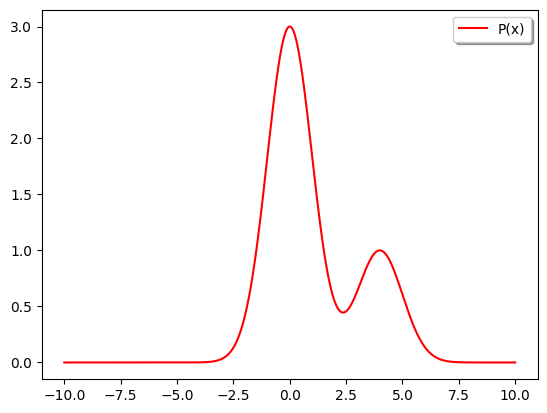

In [3]:
x_vals = np.linspace(-10, 10, 1000)
y_vals = P(x_vals)
plt.figure(1)
plt.plot(x_vals, y_vals, 'r', label='P(x)')
plt.legend(loc='upper right', shadow=True)
plt.show()

Let the functions that we want to approximate be $f(x) = x$ and $g(x) = \sin(x)$. The two values for a unnormalized $P$ are as follows:
* $\mathbb{E}[x] \approx 10.02686647165 $
* $\mathbb{E}[\sin(x)] \approx -1.15088010640 $

In [4]:
f_x = lambda x: x
g_x = lambda x: np.sin(x)
true_expected_fx = 10.02686647165
true_expected_gx = -1.15088010640

### Metropolis Hastings
For any $P(x)$, the Metropolis-Hastings algorithm proceeds as follows.
* Start at some $x_t = x_0$.
* Sample $x_i \sim Q(x|x_t)$
* $A = \min\Big(\frac{P(x_i)Q(x_t|x_i)}{P(x_t)Q(x_i|x_t)},1\Big)$
* Sample $k_i \sim Uniform[0,1]$
    * if $k_i < A$ then $x_{t+1} = x_i$
    * else $x_{t+1} = x_t$
    
As $t \rightarrow \infty$, $x_t$ comes from a normalized $P(x)$. The Markov chain takes some time to stabilize which is the burn-in phase. In the following code we ignore the first 1000 samples as burn-in.   
Here we choose $Q(x|x_t)$ as $\mathcal{N}(x_t, 1)$ which is actually equal to $Q(x_t|x)$ and should cancel but I have added it in the code for clarity.

In [5]:
Q = lambda t1, t0: np.exp(-(t1 - t0)**2/2)/(np.sqrt(2 * np.pi))
x0 = 0
xt = x0
samples = []
for i in range(100000):
    xt_candidate = np.random.normal(xt, 1)
    accept_prob = (P(xt_candidate) * Q(xt, xt_candidate))/(P(xt) * Q(xt_candidate, xt))
    if np.random.uniform(0, 1) < accept_prob:
        xt = xt_candidate
    samples.append(xt)
burn_in = 1000
samples = np.array(samples[burn_in:])
expected_f_x = np.mean(f_x(samples))
expected_g_x = np.mean(g_x(samples))
expected_f_x *= Z
expected_g_x *= Z
print('E[f(x)] = %.5f, Error = %.5f' % (expected_f_x, abs(expected_f_x - true_expected_fx)))
print('E[g(x)] = %.5f, Error = %.5f' % (expected_g_x, abs(expected_g_x - true_expected_gx)))

E[f(x)] = 10.10660, Error = 0.07973
E[g(x)] = -1.13166, Error = 0.01922


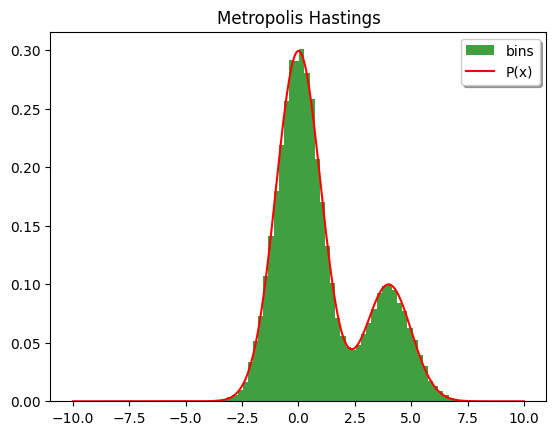

In [6]:
plt.hist(samples, bins=50, histtype='bar', facecolor='g', alpha=0.75, label='bins', density=True) # normed=1)
plt.plot(x_vals, y_vals/Z, 'r', label='P(x)')
plt.title('Metropolis Hastings')
plt.legend(loc='upper right', shadow=True)
plt.show()

## ICL using llama3

In [7]:
import copy

### Load LLM

In [8]:
import torch
from transformers import (
    LlamaForCausalLM, 
    AutoTokenizer
)

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
tokenizer = AutoTokenizer.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    use_fast=False,
)
print(f"finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    device_map="auto",   
    torch_dtype=torch.float16,
)
print(f"finish loading model")
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


finish loading tokenizer


Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.17s/it]

finish loading model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

## Define trainer and ICL

In [10]:
from llmicl.interfaces import trainers  # import RLICLTrainer

# if you have modified the code since importing for the first time, reload will update the imported package
import importlib
importlib.reload(trainers)

<module 'llmicl.interfaces.trainers' from '/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py'>

* Metropolis Hastings ran for 20000 samples with a burn in of 1000
* We will use a context of length 1000, starting after the bruning phase

In [11]:
burn_in = 1000
context_length = 1000
rescale_factor = 7.0
up_shift = 1.5

trainer = trainers.UnivariateICLTrainer(
    model=model,
    tokenizer=tokenizer,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

trainer.update_context(
    time_series=copy.copy(samples[burn_in:burn_in+context_length]), 
    mean_series=copy.copy(samples[burn_in:burn_in+context_length]), 
    sigma_series=np.zeros_like(samples[burn_in:burn_in+context_length]), 
    context_length=context_length
)

trainer.icl()

icl_object = trainer.compute_statistics()

/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:222: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


### Build the Markov chain transition kernels

In [12]:
transition_matrix_NN, transition_matrix_OT = trainer.build_tranistion_matrices(verbose=1)

/home/abenechehab/llmicl/src/llmicl/matrix_completion/utils.py:32: RuntimeWarning: invalid value encountered in divide
  normalized_probabilities = np.where(non_zero_sums_mask, np.true_divide(prob, row_sums), prob)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 388/388 [00:15<00:00, 25.40it/s]


### Visualize the matrices

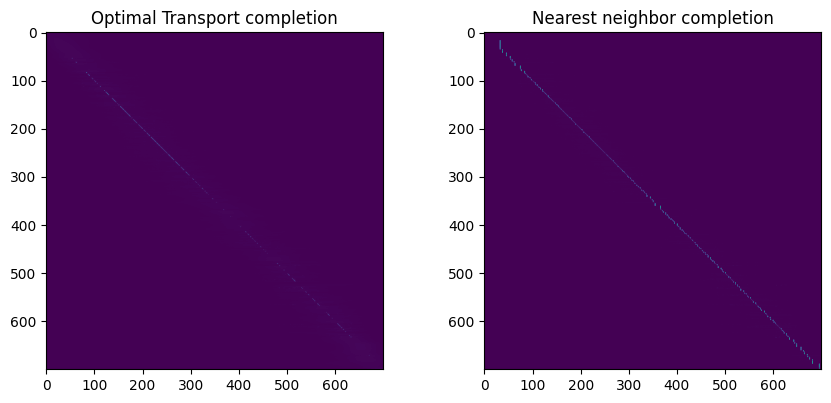

In [13]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace':0.3})
axes = list(np.array(axes).flatten())

axes[0].imshow(transition_matrix_OT[150:850,150:850])
axes[0].set_title("Optimal Transport completion")

axes[1].imshow(transition_matrix_NN[150:850,150:850])
axes[1].set_title("Nearest neighbor completion")

plt.show()

### Compute the stationary distribution

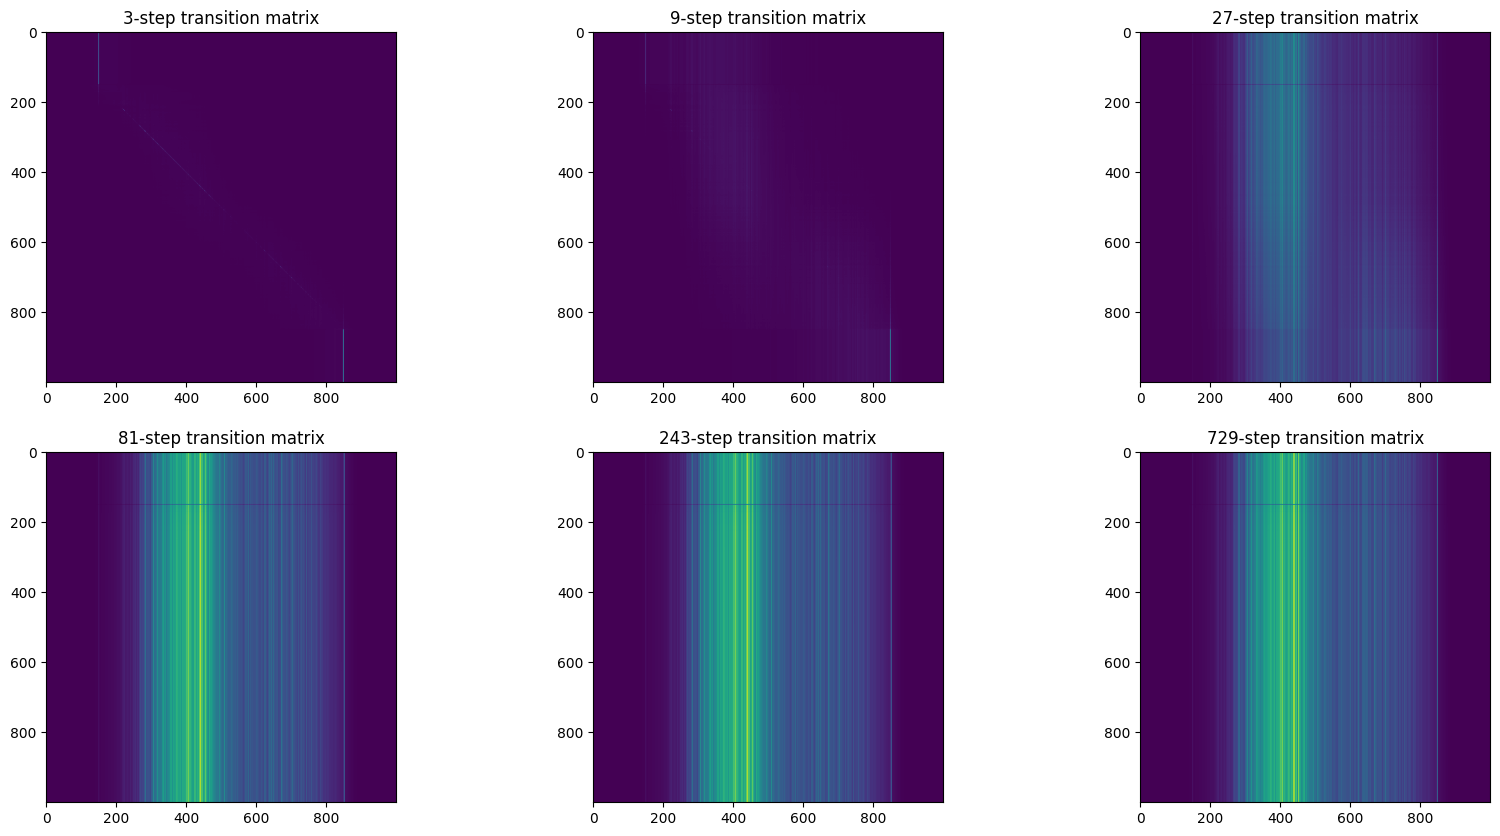

In [36]:
plt.figure(figsize=(20,10))
for power in range(1,7):
    plt.subplot(2,3,power)
    plt.imshow(np.linalg.matrix_power(transition_matrix_OT,3**power))
    plt.title(f"{3**power}-step transition matrix")
plt.show()

### The stationary distribution is the repeated row of the transition matrix after convergence
* the matrix has converged after 1000 steps

In [26]:
stationary = np.linalg.matrix_power(transition_matrix_OT[150:850, 150:850],1000)[0,:]

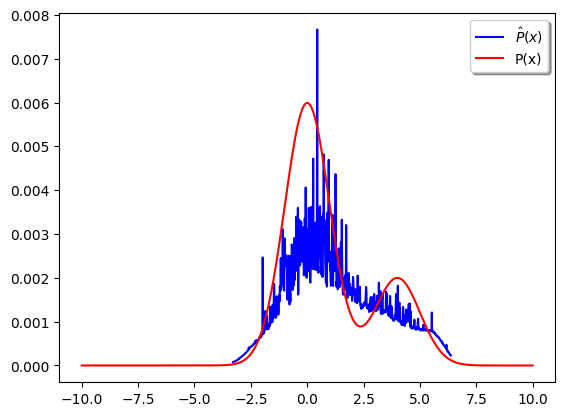

In [27]:
x = np.arange(150, 850) / 100
rescaled_x = ((x - up_shift) / rescale_factor) * (icl_object.rescaling_max - icl_object.rescaling_min) + icl_object.rescaling_min

plt.figure(1)

plt.plot(rescaled_x, stationary/sum(stationary), 'b', label=r'$\hat{P}(x)$')
plt.plot(x_vals, (y_vals/Z)/sum(y_vals/Z), 'r', label='P(x)')
plt.legend(loc='upper right', shadow=True)

plt.show()

### We can apply the same technique starting from the first samples and considering smaller context lengths

context size: 100%|████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:41<00:00, 94.00s/it]


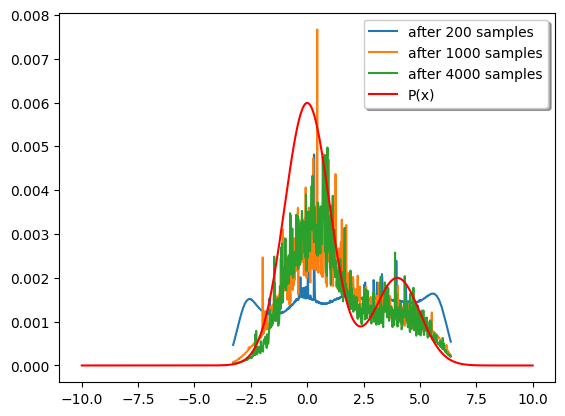

In [29]:
plt.figure(1)
for context_length in tqdm([200, 1000, 4000], desc='context size'):
    burn_in = 0
    rescale_factor = 7.0
    up_shift = 1.5
    
    trainer = trainers.UnivariateICLTrainer(
        model=model,
        tokenizer=tokenizer,
        rescale_factor=rescale_factor,
        up_shift=up_shift,
    )
    
    trainer.update_context(
        time_series=copy.copy(samples[burn_in:burn_in+context_length]), 
        mean_series=copy.copy(samples[burn_in:burn_in+context_length]), 
        sigma_series=np.zeros_like(samples[burn_in:burn_in+context_length]), 
        context_length=context_length,
    )
    
    trainer.icl()
    
    icl_object = trainer.compute_statistics()

    transition_matrix_NN, transition_matrix_OT = trainer.build_tranistion_matrices(verbose=0)

    stationary = np.linalg.matrix_power(transition_matrix_OT[150:850, 150:850],1000)[0,:]

    plt.plot(rescaled_x, stationary/sum(stationary), label=f'after {context_length} samples')

plt.plot(x_vals, (y_vals/Z)/sum(y_vals/Z), 'r', label='P(x)')
plt.legend(loc='upper right', shadow=True)
plt.show()   

### sampling

In [31]:
llm_samples = np.random.choice(rescaled_x, size=(20000), replace=True, p=stationary/sum(stationary))

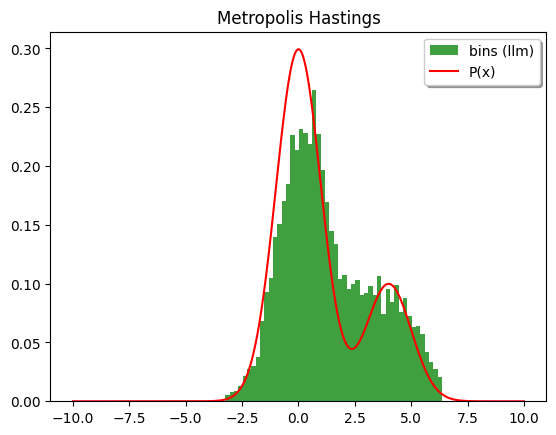

In [33]:
plt.hist(llm_samples, bins=50, histtype='bar', facecolor='g', alpha=0.75, label='bins (llm)', density=True) # normed=1)
plt.plot(x_vals, y_vals/Z, 'r', label='P(x)')
plt.title('Metropolis Hastings')
plt.legend(loc='upper right', shadow=True)
plt.show()